In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np

# Read Data

In [2]:
w1, w2, w3, w4, w5 = 0.2, 0.2, 0.2, 0.2, 0.2
minmax_scaler = MinMaxScaler()

df = pd.read_csv("course_labeled.csv")
df["pos_ratio"] = np.nan_to_num(df["positive"] / df[["negative", "neutral", "positive"]].sum(axis=1))
df["neg_ratio"] = np.nan_to_num(df["negative"] / df[["negative", "neutral", "positive"]].sum(axis=1))
df["composite_score"] = df['composite_score'] = (
    w1 * MinMaxScaler().fit_transform(df[['num_users']]).ravel() +
    w2 * MinMaxScaler().fit_transform(df[['average_completion_rate']]).ravel() +
    w3 * df['pos_ratio'] -
    w4 * df['neg_ratio'] +
    w5 * MinMaxScaler().fit_transform(df[['resource']]).ravel()
)
df

,id,name,resource,total_comments,average_completion_rate,negative,positive,neutral,num_users,course_classification,pos_ratio,neg_ratio,composite_score
0,C_655852,系列课-已结课无回顾时长,162,1.0,0.666667,0.0,0.0,0.0,48,normal,0.0,0.0,0.145182
1,C_655850,系列课-开课未开始,91,1.0,0.000000,0.0,0.0,0.0,47,bad,0.0,0.0,0.006640
2,C_654554,系列课-开课中,99,1.0,0.655651,0.0,0.0,0.0,47,normal,0.0,0.0,0.138357
3,C_654506,系列课-开课已结束有回顾时长,3,1.0,0.655651,0.0,0.0,0.0,47,bad,0.0,0.0,0.131317
4,C_629558,医学免疫学与病原生物学,91,1.0,0.655651,0.0,0.0,0.0,48,normal,0.0,0.0,0.137771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,C_2338005,（疾风计划）算法设计与分析,74,0.0,NaN,0.0,0.0,0.0,1,NaN,0.0,0.0,NaN
3777,C_2338076,（疾风计划）软件工程,103,0.0,NaN,0.0,0.0,0.0,1,NaN,0.0,0.0,NaN
3778,C_2341259,（疾风计划）面向对象程序设计（C++）,76,0.0,NaN,0.0,0.0,0.0,1,NaN,0.0,0.0,NaN
3779,C_2337996,（疾风计划）数据结构(下),324,0.0,NaN,0.0,0.0,0.0,1,NaN,0.0,0.0,NaN


<Axes: xlabel='course_classification', ylabel='count'>

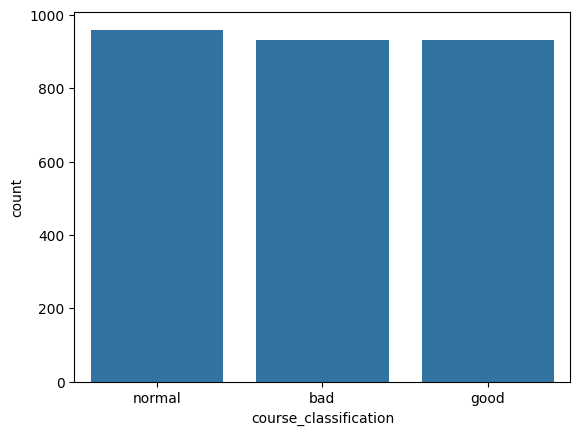

In [3]:
import seaborn as sns

sns.countplot(df, x="course_classification")

In [3]:
df["average_completion_rate"].mean()

np.float64(0.6550275845610755)

In [473]:
df = df.dropna()
print(df.shape)

(2822, 13)


In [474]:
df.keys()

Index(['id', 'name', 'resource', 'total_comments', 'average_completion_rate',
       'negative', 'positive', 'neutral', 'num_users', 'course_classification',
       'pos_ratio', 'neg_ratio', 'composite_score'],
      dtype='object')

In [475]:
X = df.drop(columns=['id',
                     'name',
                     'course_classification',])
y = df['course_classification']

In [476]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [477]:
X

,resource,total_comments,average_completion_rate,negative,positive,neutral,num_users,pos_ratio,neg_ratio,composite_score
0,162,1.0,0.666667,0.0,0.0,0.0,48,0.0,0.0,0.145182
1,91,1.0,0.000000,0.0,0.0,0.0,47,0.0,0.0,0.006640
2,99,1.0,0.655651,0.0,0.0,0.0,47,0.0,0.0,0.138357
3,3,1.0,0.655651,0.0,0.0,0.0,47,0.0,0.0,0.131317
4,91,1.0,0.655651,0.0,0.0,0.0,48,0.0,0.0,0.137771
...,...,...,...,...,...,...,...,...,...,...
2817,78,1.0,0.835524,0.0,0.0,0.0,355,0.0,0.0,0.173058
2818,204,1.0,0.736111,0.0,0.0,0.0,103,0.0,0.0,0.162198
2819,26,1.0,0.635000,0.0,0.0,0.0,90,0.0,0.0,0.128910
2820,42,1.0,0.655651,0.0,0.0,0.0,75,0.0,0.0,0.134201


# Random Forest

In [478]:
rf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(criterion="entropy", max_depth=15, min_samples_split=5, bootstrap=False, class_weight="balanced"))
])
rf.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=15,
                                        min_samples_split=5))])

In [479]:
y_pred = rf.predict(X_test)

accuracy: 1.0
F1 score: 1.0


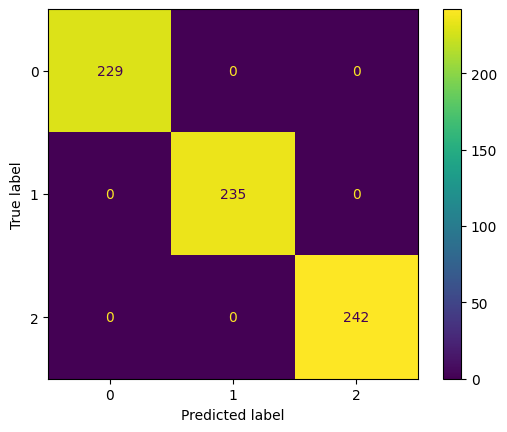

In [480]:
rf_acc = accuracy_score(y_test,y_pred)
rf_f1 = f1_score(y_test,y_pred, average='macro')
print(f'accuracy: {rf_acc}')
print(f'F1 score: {rf_f1}')
rf_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()
plt.show()

In [481]:
scores = cross_val_score(rf,X,y,cv=10)
scores.mean(), scores.std()

(np.float64(0.999645390070922), np.float64(0.0010638297872340274))

# K nearest neighbors

In [482]:
from sklearn.neighbors import KNeighborsClassifier
knn = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(3))])

In [483]:
knn.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

In [484]:
y_pred = knn.predict(X_test)

accuracy: 0.9575070821529745
F1 score: 0.9578675622028343


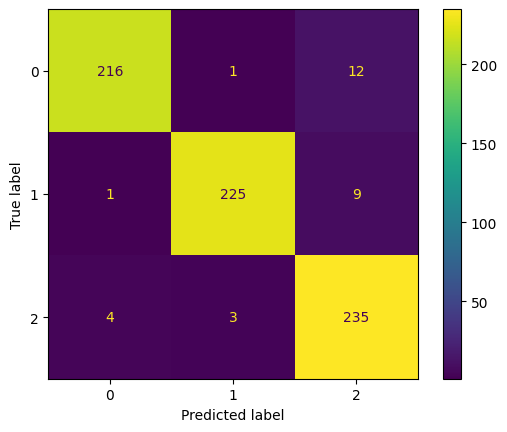

In [485]:
knn_acc = accuracy_score(y_test,y_pred)
knn_f1 = f1_score(y_test,y_pred,average="macro")
print(f'accuracy: {knn_acc}')
print(f'F1 score: {knn_f1}')
knn_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
disp.plot()
plt.show()

In [486]:
scores = cross_val_score(knn,X,y,cv=10)
scores.mean(), scores.std()

(np.float64(0.9585356990702454), np.float64(0.01029762879718464))

# Support Vector Machine

In [487]:
from sklearn.svm import SVC
svc = Pipeline([
    ("scaler", StandardScaler()), 
    ("clf", SVC(C=7, kernel="linear"))
])

In [488]:
svc.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=7, kernel='linear'))])

In [489]:
y_pred = svc.predict(X_test)

accuracy: 0.9815864022662889
F1 score: 0.9816892155233762


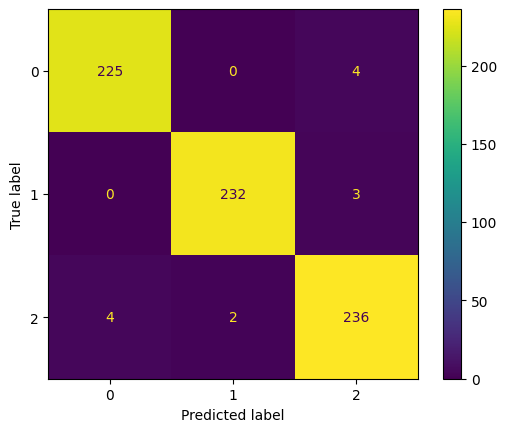

In [490]:
svc_acc = accuracy_score(y_test, y_pred)
svc_f1 = f1_score(y_test, y_pred, average = "macro")
print(f'accuracy: {svc_acc}')
print(f'F1 score: {svc_f1}')
svc_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm)
disp.plot()
plt.show()

In [491]:
scores = cross_val_score(svc,X,y,cv=10)
scores.mean(), scores.std()

(np.float64(0.9787421998345989), np.float64(0.01129282624291542))

# Decision Tree Classifier

In [492]:
from sklearn.tree import DecisionTreeClassifier
tree = Pipeline([
    ("scaler", StandardScaler()), 
    ("clf", DecisionTreeClassifier())
])

In [493]:
tree.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier())])

In [494]:
y_pred = tree.predict(X_test)

accuracy: 1.0
F1 score: 1.0


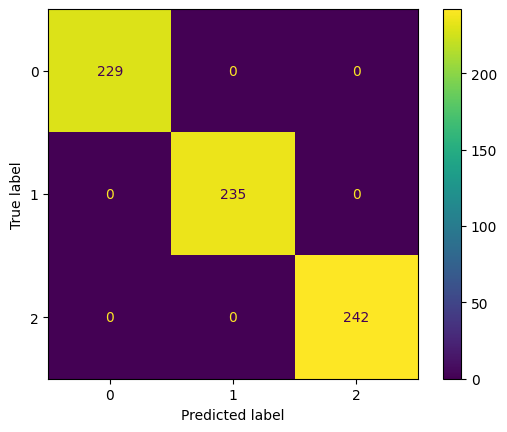

In [495]:
tree_acc = accuracy_score(y_test, y_pred)
tree_f1 = f1_score(y_test, y_pred, average = "macro")
print(f'accuracy: {tree_acc}')
print(f'F1 score: {tree_f1}')
tree_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=tree_cm)
disp.plot()
plt.show()

In [496]:
scores = cross_val_score(tree,X,y,cv=10)
scores.mean(), scores.std()

(np.float64(0.999645390070922), np.float64(0.0010638297872340274))

# Evaluation

/tmp/ipykernel_149760/689458480.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')
/tmp/ipykernel_149760/689458480.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


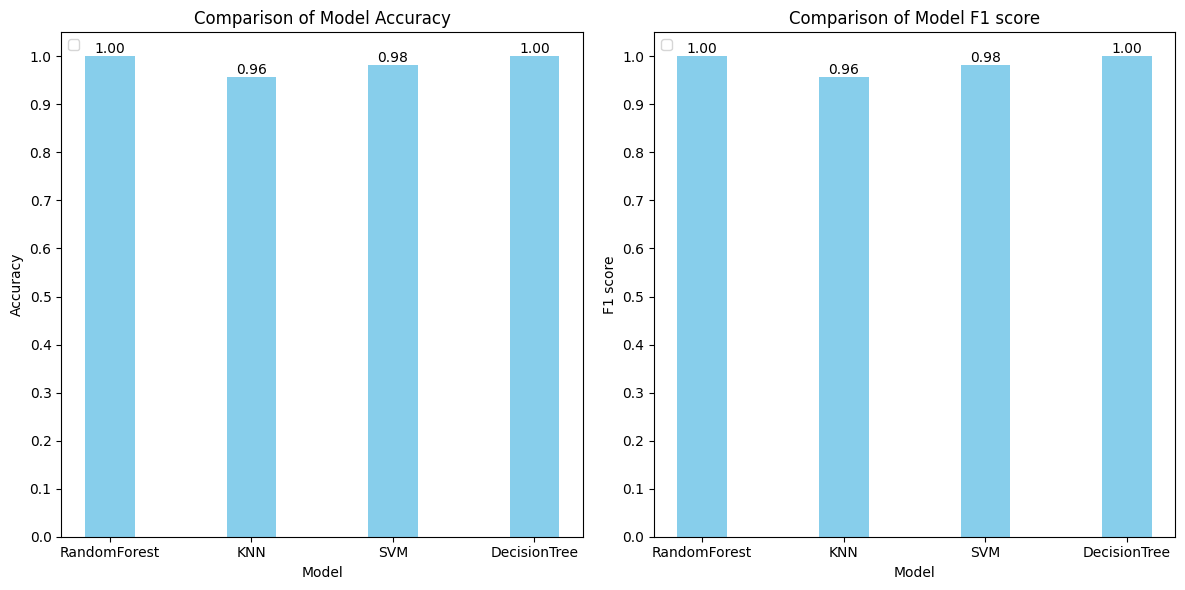

In [497]:
import numpy as np
models = ['RandomForest', 'KNN', 'SVM', 'DecisionTree']
acc = [rf_acc, knn_acc, svc_acc, tree_acc]
f1 = [rf_f1, knn_f1, svc_f1, tree_f1]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(12, 6))

# Subplot cho Age Accuracy
plt.subplot(1, 2, 1)  # 1 dòng, 2 cột, subplot 1
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue']  # Chỉ định màu của các cột
plt.bar(index, acc, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.xticks(index, models)
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, acc[i] , f'{acc[i]:.2f}', ha='center', va='bottom', color='black')
plt.legend(loc='upper left')

# Subplot cho Gender Accuracy
plt.subplot(1, 2, 2)  # 1 dòng, 2 cột, subplot 2
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue']  # Chỉ định màu của các cột
plt.bar(index, f1, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 score')
plt.title('Comparison of Model F1 score')
plt.xticks(index, models)
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, f1[i], f'{f1[i]:.2f}', ha='center', va='bottom', color='black')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import joblib

# save
joblib.dump(tree, "course_clf.pkl") 

['course_clf.pkl']